# Marker Model Training

In [1]:
%matplotlib inline
import os
import os.path as osp
import celldom
import pandas as pd
import numpy as np
from cvutils import rectlabel
import matplotlib.pyplot as plt
import imgaug
import keras
import wandb
from wandb.keras import WandbCallback
from sklearn.model_selection import train_test_split
from celldom.config import marker_config
from celldom.dataset import marker_dataset
from mrcnn import model as mrcnn_model_lib
from mrcnn import visualize as mrcnn_viz
from celldom.dataset import utils as dataset_utils
from cvutils.mrcnn.session import init_keras_session
from celldom.warnings import disable_mrcnn_warnings
from cvutils.mrcnn import model as mrcnn_model
from celldom import seed

init_keras_session()
disable_mrcnn_warnings()
plt.gray()

marker_data_dir = osp.join(celldom.get_dataset_dir(), 'training', 'marker', 'r0.6')

model_dir = osp.join(celldom.get_model_dir(), 'r0.7', 'marker_model')
model_file = 'marker_model.h5'
model_path = osp.join(model_dir, model_file)

Using TensorFlow backend.


<Figure size 432x288 with 0 Axes>

In [2]:
marker_data_dir

'/lab/data/celldom/dataset/training/marker/r0.6'

In [3]:
model_dir

'/lab/data/celldom/model/r0.7/marker_model'

In [4]:
images = dataset_utils.get_data_files(marker_data_dir, patterns=['*.tif'])
images['chip'] = images['image_name'].apply(lambda v: v.split('_')[0])

#REMOVE
images = images[images['chip'] == 'G01']

print('Number of images found =', len(images))
images[:3]

Number of images found = 250


,image_name,image_path,annot_path,annot_exists,chip
240,G01_BF_16X_St_000_Apt_004_F_000_201802170000.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True,G01
457,G01_BF_16X_St_000_Apt_004_F_000_201802171700.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,False,G01
525,G01_BF_16X_St_000_Apt_004_F_000_201802191500.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True,G01


In [5]:
images.groupby(['chip', 'annot_exists']).size().unstack()

annot_exists,False,True
chip,,
G01,218,32


In [6]:
images['annot_exists'].value_counts()

False    218
True      32
Name: annot_exists, dtype: int64

In [7]:
images = images[images['annot_exists']]
assert images['annot_exists'].all()
len(images)

32

In [8]:
images.groupby('chip').size()

chip
G01    32
dtype: int64

In [9]:
idx_train, idx_test = train_test_split(np.arange(len(images)), test_size=.3, random_state=seed)
assert len(idx_train) + len(idx_test) == len(images)
assert len(np.intersect1d(idx_train, idx_test)) == 0

image_paths_train = images['image_path'].iloc[idx_train].values
image_paths_test = images['image_path'].iloc[idx_test].values

In [10]:
pd.concat([
    images.iloc[idx_train].groupby('chip').size().rename('training'),
    images.iloc[idx_test].groupby('chip').size().rename('test')
], axis=1)

,training,test
chip,,
G01,22,10


In [11]:
dataset_train = marker_dataset.MarkerDataset(reflect_images=True)
dataset_train.initialize(image_paths_train)
dataset_train.prepare()

dataset_test = marker_dataset.MarkerDataset(reflect_images=True)
dataset_test.initialize(image_paths_test)
dataset_test.prepare()

In [12]:
dataset_train.load_image(0).shape, dataset_train.load_image(0).dtype

((1200, 1600, 3), dtype('uint8'))

In [13]:
dataset_train.load_mask(0)[0].shape

(1200, 1600, 15)

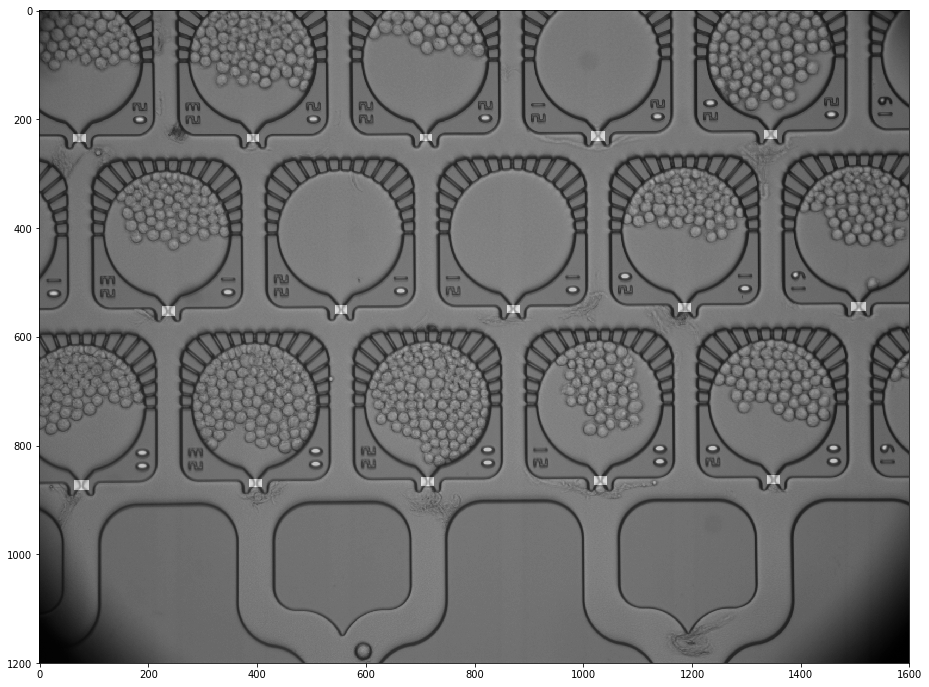

In [14]:
image_id = np.flatnonzero(images.iloc[idx_train]['chip'] == 'G01')[0]
alpha = .5
plt.imshow(
    dataset_train.load_image(image_id)[..., 0] + \
    alpha * 255 * dataset_train.load_mask(image_id)[0].max(axis=2)
)
plt.gcf().set_size_inches(16, 12)

In [15]:
# Fetch RCNN training configuration
train_config = marker_config.MarkerTrainingConfig()

# Set these step counts to equal data size so that a single epoch is easier to describe
# train_config.STEPS_PER_EPOCH = len(image_paths_train)
# train_config.VALIDATION_STEPS = len(image_paths_test)
train_config.STEPS_PER_EPOCH = 100
train_config.VALIDATION_STEPS = len(image_paths_test)
train_config.IMAGES_PER_GPU = 1
train_config.GPU_COUNT = 2
train_config.BATCH_SIZE = train_config.IMAGES_PER_GPU * train_config.GPU_COUNT
    
train_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
EXPECTED_CLASS_COUNTS          {'Marker': 1}
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      2
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE   

In [16]:
model_dir, model_path

('/lab/data/celldom/model/r0.7/marker_model',
 '/lab/data/celldom/model/r0.7/marker_model/marker_model.h5')

In [17]:
assert model_dir
!rm -rf $model_dir/*
model = mrcnn_model.get_model(mode="training", config=train_config, model_dir=model_dir, init_with='coco')

In [18]:
wandb.init()

W&B Run: https://app.wandb.ai/hammerlab/celldom/runs/c16vfuwj
Wrap your training loop with `with wandb.monitor():` to display live results.


W&B Run https://app.wandb.ai/hammerlab/celldom/runs/c16vfuwj

In [19]:
aug = imgaug.augmenters.Sometimes(0.2, [
    imgaug.augmenters.Affine(rotate=(-10, 10))
])

In [20]:
%%time
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
learning_rate = keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_loss', mode='min', verbose=1)

# Saving models like this with MaskRCNN appears to be broken
# save_model = keras.callbacks.ModelCheckpoint(
#     osp.join(model_dir, model_file.replace('.h5', '_head.h5')), 
#     monitor='val_loss', mode='min', verbose=1, 
#     save_best_only=True, save_weights_only=False, period=1)

with wandb.monitor(display=False):
    # Classifier heads only
    model.train(
        dataset_train, dataset_test, 
        learning_rate=train_config.LEARNING_RATE, 
        epochs=50, 
        augmentation=aug,
        custom_callbacks=[WandbCallback(save_model=False), early_stopping, learning_rate],
        #custom_callbacks=[early_stopping, learning_rate],
        layers='heads'
    )

Resuming run: https://app.wandb.ai/hammerlab/celldom/runs/c16vfuwj


Instructions for updating:
Use the retry module or similar alternatives.

Starting at epoch 0. LR=0.001

Checkpoint Path: /lab/data/celldom/model/r0.7/marker_model/celldom-marker20181003T1039/mask_rcnn_celldom-marker_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeD

In [ ]:
%%time
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min')
learning_rate = keras.callbacks.ReduceLROnPlateau(patience=3, monitor='val_loss', mode='min', verbose=1)

with wandb.monitor(display=False):
    # Fine-tuning
    model.train(
        dataset_train, dataset_test, 
        learning_rate=train_config.LEARNING_RATE, 
        epochs=100, 
        augmentation=aug,
        custom_callbacks=[WandbCallback(save_model=False), early_stopping, learning_rate],
        #custom_callbacks=[early_stopping, learning_rate],
        layers='all'
    )

Resuming run: https://app.wandb.ai/hammerlab/celldom/runs/c16vfuwj



Starting at epoch 50. LR=0.001

Checkpoint Path: /lab/data/celldom/model/r0.7/marker_model/celldom-marker20181003T1039/mask_rcnn_celldom-marker_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_bran

In [ ]:
#plt.plot(model.keras_model.history.history['val_loss'])

In [22]:
!find $model_dir | sort

/lab/data/celldom/model/r0.7/marker_model
/lab/data/celldom/model/r0.7/marker_model/celldom-marker20181002T1921
/lab/data/celldom/model/r0.7/marker_model/celldom-marker20181002T1921/events.out.tfevents.1538508134.246ed387eb18
/lab/data/celldom/model/r0.7/marker_model/celldom-marker20181002T1921/events.out.tfevents.1538508880.246ed387eb18
/lab/data/celldom/model/r0.7/marker_model/celldom-marker20181002T1921/mask_rcnn_celldom-marker_0001.h5
/lab/data/celldom/model/r0.7/marker_model/celldom-marker20181002T1921/mask_rcnn_celldom-marker_0002.h5
/lab/data/celldom/model/r0.7/marker_model/celldom-marker20181002T1921/mask_rcnn_celldom-marker_0003.h5
/lab/data/celldom/model/r0.7/marker_model/celldom-marker20181002T1921/mask_rcnn_celldom-marker_0004.h5
/lab/data/celldom/model/r0.7/marker_model/celldom-marker20181002T1921/mask_rcnn_celldom-marker_0005.h5
/lab/data/celldom/model/r0.7/marker_model/celldom-marker20181002T1921/mask_rcnn_celldom-marker_0006.h5
/lab/data/celldom/model/r0.7/marker_model/

In [23]:
!cp /lab/data/celldom/model/r0.7/marker_model/celldom-marker20181002T1921/mask_rcnn_celldom-marker_0060.h5 $model_path
!ls -lah $model_path

-rwxrwxrwx 1 nobody nogroup 171M Oct  2 20:13 /lab/data/celldom/model/r0.7/marker_model/marker_model.h5


## Inference

In [24]:
model_path

'/lab/data/celldom/model/r0.7/marker_model/marker_model.h5'

In [47]:
# Re-initialize model from exported weights in inference mode
inference_config = marker_config.MarkerInferenceConfig()

In [48]:
inference_config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        50
DETECTION_MIN_CONFIDENCE       0.5
DETECTION_NMS_THRESHOLD        0.3
EXPECTED_CLASS_COUNTS          {'Marker': 1}
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE   

In [39]:
model = mrcnn_model.get_model('inference', inference_config, model_dir, init_with='file', file=model_path)

In [40]:
len(dataset_test.image_ids)

2

In [41]:
images.head()

,image_name,image_path,annot_path,annot_exists,chip
201,G01_BF_16X_St_000_Apt_004_F_000_201802170000.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True,G01
531,G01_BF_16X_St_000_Apt_004_F_000_201802191500.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True,G01
261,G01_BF_16X_St_002_Apt_000_F_000_201802192300.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True,G01
355,G01_BF_16X_St_002_Apt_004_F_000_201802200600.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True,G01
435,G01_BF_16X_St_002_Apt_020_F_000_201802201600.tif,/lab/data/celldom/dataset/training/marker/r0.6...,/lab/data/celldom/dataset/training/marker/r0.6...,True,G01


In [44]:
def show_prediction(dataset, image_id):
    image, image_meta, gt_class_id, gt_bbox, gt_mask = \
    mrcnn_model_lib.load_image_gt(
        dataset, inference_config, image_id,
        use_mini_mask=False
    )
    r = model.detect([image])[0]
    mrcnn_viz.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], show_bbox=True, show_mask=False)

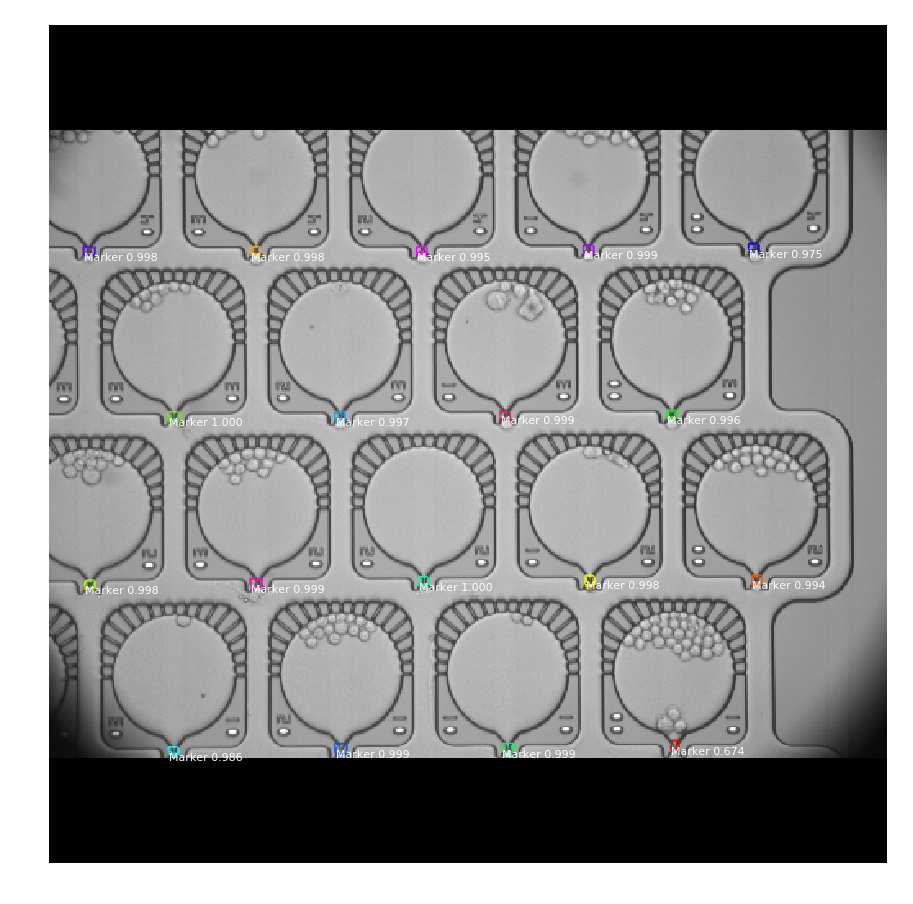

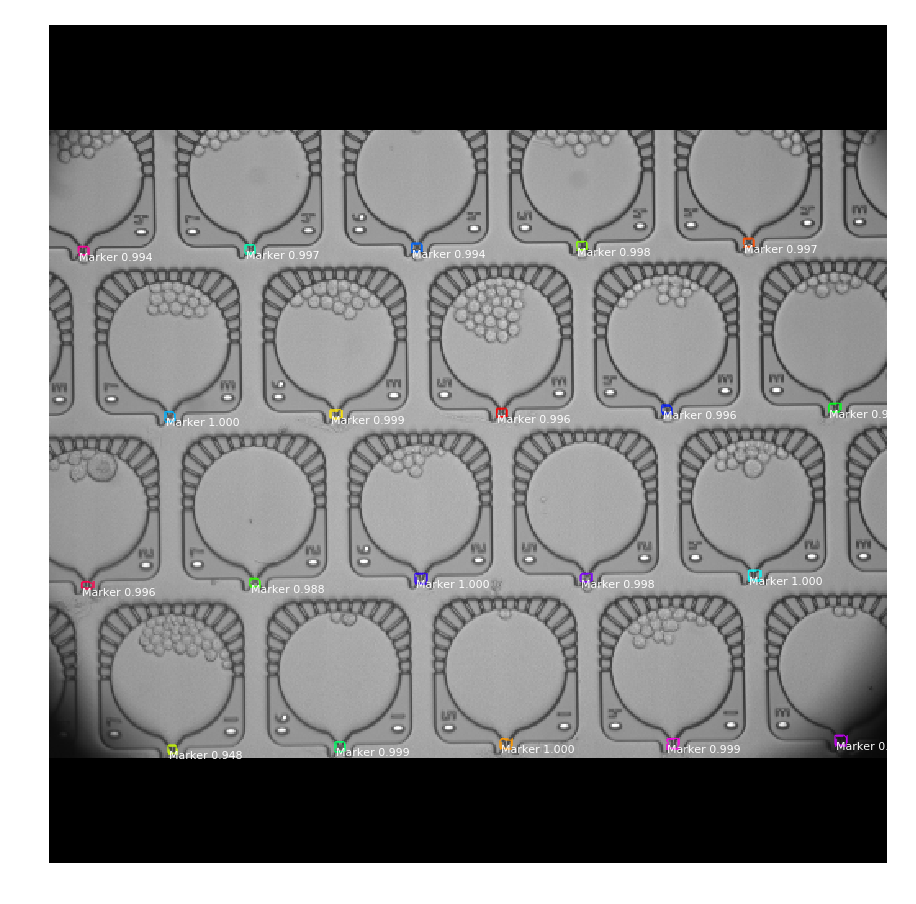

CPU times: user 2.75 s, sys: 1.39 s, total: 4.14 s
Wall time: 2.39 s


In [49]:
%%time
image_ids = pd.Series(dataset_test.image_ids).sample(n=10)
#image_ids = pd.Series(dataset_train.image_ids).sample(n=4)
for iid in image_ids:
    show_prediction(dataset_test, iid)

In [18]:
image_id = 8
image, image_meta, gt_class_id, gt_bbox, gt_mask = \
mrcnn_model_lib.load_image_gt(
    dataset_test, inference_config, image_id,
    use_mini_mask=False
)

In [21]:
%%time
r = model.detect([dataset_test.load_image(image_id)])[0]

CPU times: user 283 ms, sys: 338 ms, total: 621 ms
Wall time: 226 ms


In [22]:
r['masks'].shape

(1200, 1600, 13)

In [23]:
r['rois']

array([[ 535, 1180,  551, 1194],
       [ 544,  765,  560,  781],
       [ 850, 1395,  867, 1411],
       [ 230,  553,  246,  569],
       [1175, 1195, 1189, 1209],
       [ 238,  138,  255,  155],
       [ 214, 1381,  231, 1397],
       [ 876,  149,  892,  165],
       [ 223,  965,  240,  982],
       [ 866,  565,  883,  581],
       [ 858,  979,  874,  993],
       [ 551,  353,  567,  367],
       [1181,  780, 1195,  793]], dtype=int32)

In [24]:
image_meta

array([8.00e+00, 1.20e+03, 1.60e+03, 3.00e+00, 5.12e+02, 5.12e+02,
       3.00e+00, 6.40e+01, 0.00e+00, 4.48e+02, 5.12e+02, 3.20e-01,
       1.00e+00, 1.00e+00])

In [ ]:
# To validate mrcnn resizing:
# from mrcnn import utils as mrcnn_utils
# rsz_img_res, rsz_window, rsz_scale, rsz_padding, rsz_crop = mrcnn_utils.resize_image(rsz_img, min_dim=1024, max_dim=1408, min_scale=0)
# # image.astype(image_dtype), window, scale, padding, crop
# rsz_img_res.shape, rsz_window, rsz_scale, rsz_padding, rsz_crop